# 3-Logistic-Regression

Follow the notebook to understand the background and implementation of Logistic Regression using built-in libraries and functions followed by a visualization of their associated graphs and analysis of their accuracy.

First, we need to setup the dependencies and import the dataset.

In [1]:
#import the libraries and classes
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Pre-Processing Data

Before implementing the algorithm, we need to examine our input data to see how to handle it. Here, a dataset containing Rotten Tomatoes Ratings and Reviews is loaded in. 

Note that the dimensions of the datafile are 17712 rows x 22 columns. Since we want to save some computing time and costs, we only use a small portion of the dataset, as parsed below.

In [2]:
#load and examine the raw contents of the dataset
df = pd.read_csv('rotten_tomatoes_movies.csv', sep=',')
df

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2/12/10,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",4/30/10,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",10/5/79,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",4/13/57,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1/1/54,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17707,m/zoot_suit,Zoot Suit,Mexican-American gangster Henry Reyna (Daniel ...,NaN,R,"Drama, Musical & Performing Arts",Luis Valdez,Luis Valdez,"Daniel Valdez, Edward James Olmos, Charles Aid...",10/2/81,...,MCA Universal Home Video,Rotten,56.0,9.0,Upright,74.0,1195.0,2,5,4
17708,m/zootopia,Zootopia,From the largest elephant to the smallest shre...,The brilliantly well-rounded Zootopia offers a...,PG,"Action & Adventure, Animation, Comedy","Byron Howard, Rich Moore, Jared Bush","Jared Bush, Phil Johnston","J.K. Simmons, Kristen Bell, Octavia Spencer, A...",3/4/16,...,Walt Disney Animation Studios,Certified-Fresh,98.0,291.0,Upright,92.0,101511.0,50,285,7
17709,m/zorba_the_greek,Zorba the Greek,Traveling to inspect an abandoned mine his fat...,NaN,NR,"Action & Adventure, Art House & International,...",NaN,NaN,"Anthony Quinn, Alan Bates, Irene Papas, Lila K...",12/17/64,...,Fox,Fresh,80.0,10.0,Upright,86.0,7146.0,0,8,2
17710,m/zulu,Zulu,"In 1879, the Zulu nation hands colonial Britis...",Zulu patiently establishes a cast of colorful ...,PG,"Classics, Drama","Cy Endfield, Cyril Endfield","Cy Endfield, John Prebble","Stanley Baker, Jack Hawkins, Ulla Jacobsson, J...",6/17/64,...,Paramount Pictures,Fresh,96.0,23.0,Upright,91.0,30193.0,6,22,1


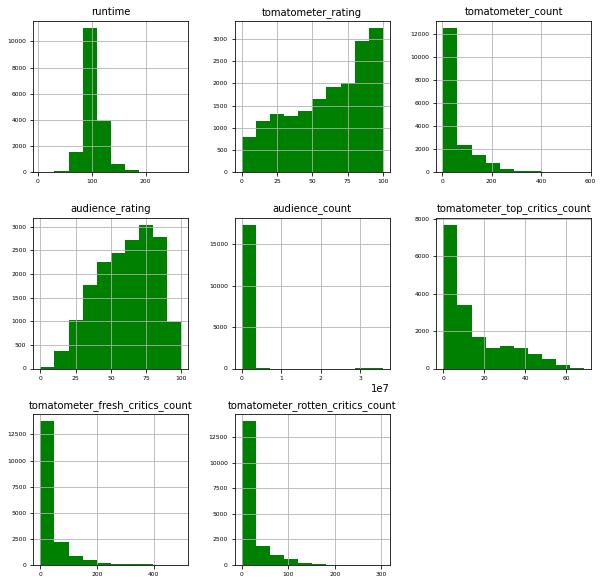

In [3]:
#To better understand the values and info from each column, we plot the numeric columns into figures

fig = df.hist(figsize=(10,10), color='green', xlabelsize=6, ylabelsize=6)
[x.title.set_size(10) for x in fig.ravel()]
plt.show()

Based on the output of these graphs, we can see that runtime and sections with 'count' in the title have a more linear behaviour. The remaining columns that we can apply logistic regression include the tomatometer ratings and audience ratings. 

Considering that the original dataset includes a section called tomatometer_status that is categorized either as Rotten, Fresh, or Certified-Fresh, we will compared the tomato ratings to the audience ratings to see the variance between the two.

In [4]:
#create a new dataframe that includes only the fields that we want to focus on
df_v = pd.DataFrame()
df_v = pd.concat([df_v, df['movie_title'],  df['tomatometer_status'], df['audience_rating']], axis=1)
df_v = pd.DataFrame(df_v.head(1000)) #limit the size of the dataframe to 1000 movies
df_v #print the dataframe

,movie_title,tomatometer_status,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,Rotten,53.0
1,Please Give,Certified-Fresh,64.0
2,10,Fresh,53.0
3,12 Angry Men (Twelve Angry Men),Certified-Fresh,97.0
4,"20,000 Leagues Under The Sea",Fresh,74.0
...,...,...,...
995,Alice (Neco z Alenky),Fresh,80.0
996,The Last Man on Earth,Fresh,69.0
997,Sherman's March,Fresh,85.0
998,Bad Girls,Rotten,40.0


In [5]:
#change the status from Fresh => 1 and Rotten => 0
df_v['tomatometer_status'] = df_v['tomatometer_status'].map({'Rotten': 0, 'Fresh': 1})
df_v

,movie_title,tomatometer_status,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,0.0,53.0
1,Please Give,NaN,64.0
2,10,1.0,53.0
3,12 Angry Men (Twelve Angry Men),NaN,97.0
4,"20,000 Leagues Under The Sea",1.0,74.0
...,...,...,...
995,Alice (Neco z Alenky),1.0,80.0
996,The Last Man on Earth,1.0,69.0
997,Sherman's March,1.0,85.0
998,Bad Girls,0.0,40.0


In [6]:
#Since there is no Certified Rotten, we discard the Certified Fresh (NaNs) to have a more clear comparison
df_use = df_v.dropna(axis='rows')
df_use

,movie_title,tomatometer_status,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,0.0,53.0
2,10,1.0,53.0
4,"20,000 Leagues Under The Sea",1.0,74.0
5,"10,000 B.C.",0.0,37.0
7,3:10 to Yuma,1.0,79.0
...,...,...,...
995,Alice (Neco z Alenky),1.0,80.0
996,The Last Man on Earth,1.0,69.0
997,Sherman's March,1.0,85.0
998,Bad Girls,0.0,40.0


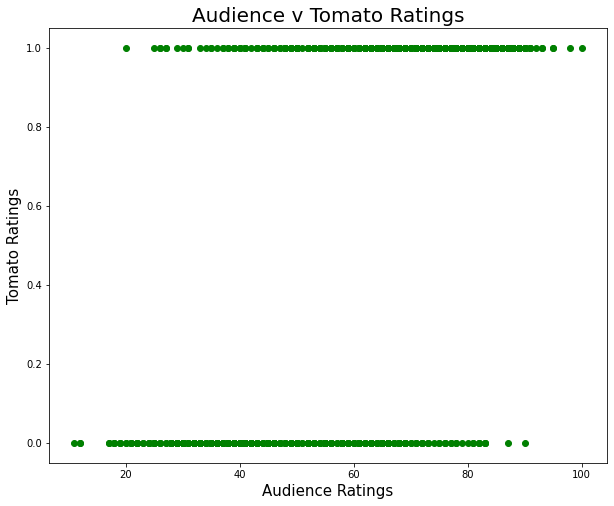

In [7]:
#plot the updated dataframe to visualize the behavior
plt.figure(figsize = (10, 8))
plt.scatter(df_v.audience_rating, df_v.tomatometer_status, color='green')
plt.title('Audience v Tomato Ratings', fontsize = 20)
plt.xlabel('Audience Ratings', fontsize = 15)
plt.ylabel('Tomato Ratings', fontsize = 15)
plt.show()

Since we can see clear boolean categories, we proceed to the next step.

## Background: Sigmoid Function

The visual representation of logistic regression follows the behaviour of a sigmoid function and plotted below.

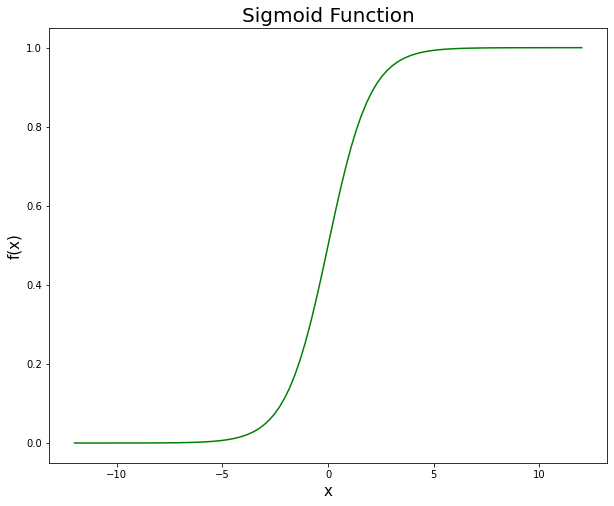

In [8]:
#backbone of the logistic regression algorithm
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z)) # 1/(1 + e^-z)

domain = np.linspace(-12.0, 12.0, 100)

plt.figure(figsize = (10, 8))
plt.plot(domain, sigmoid(domain), color = 'green')
plt.title('Sigmoid Function', fontsize = 20)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.show()

## Implement Logistic Regression

In [9]:
#create 2 new dataframes that will become our x,y values for the ML model
x = pd.DataFrame(); y = pd.DataFrame()
x = df_use.drop(['tomatometer_status', 'movie_title'], axis=1) #get rid of the title (strings) and the tomato values
y = df_use['tomatometer_status'] #move the tomato values here

In [10]:
#Standardizing features
sc = StandardScaler()
x = sc.fit_transform(x) #reduce the data to smaller values

#split the data to train based on 70% of the inputs and test on the remaining 30%
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.3, random_state = 30)

In [11]:
#train the model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train,y_train) 

#accuracy of the model
print("Training accuracy is: ", logreg.score(X_train, y_train))
print("Testing accuracy is: ",logreg.score(X_test, y_test))

Training accuracy is:  0.7584459459459459
Testing accuracy is:  0.7607843137254902


In [12]:
#generate the test values
from scipy.special import expit

y_pred_test = logreg.predict(X_test) #using the testing values

#apply the equation of a line using the coefficients and intercepts from the model and apply the sigmoid function
sig_y_test = x * logreg.coef_ + logreg.intercept_
sig_test = expit(sig_y_test) #sigmoid function using scipy expit

In [13]:
#scale the inputs to be plotted
df_scaled = df_use.drop(['movie_title'], axis=1)
scaled_y = sc.fit_transform(df_scaled)

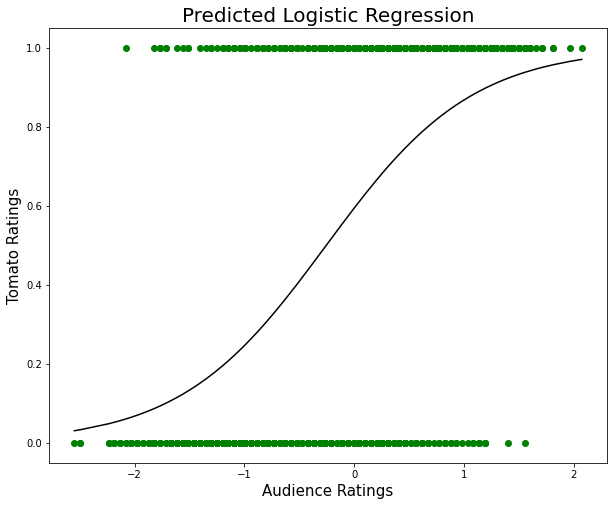

In [14]:
plt.figure(figsize = (10, 8))
plt.scatter(scaled_y[:,1], df_use.tomatometer_status, color='green')
plt.plot(sorted(x), sorted(sig_test), color='black')
plt.title('Predicted Logistic Regression', fontsize = 20)
plt.xlabel('Audience Ratings', fontsize = 15)
plt.ylabel('Tomato Ratings', fontsize = 15)
plt.show()

## Performance Analysis

Since we used a Sklearn's built in functions, we can't plot a cost function from their capabilities. Rather than building another LR model, we will use Sklearn's accuracy scoring and confusion matrices instead. 

In [15]:
test_vals = [0.1,0.3, 0.5]
state_vals = [0, 15, 30]
for t_size in test_vals:
  print(f"\nTest size = {t_size}")
  for r_state in state_vals:
    print(f"Random state = {r_state}")
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size = t_size, random_state = r_state)

    print(f"Training accuracy is: {logreg.score(X_train, y_train)}")
    print(f"Test accuracy is: {logreg.score(X_test, y_test)}\n")


Test size = 0.1
Random state = 0
Training accuracy is: 0.7506561679790026
Test accuracy is: 0.8352941176470589

Random state = 15
Training accuracy is: 0.7572178477690289
Test accuracy is: 0.7764705882352941

Random state = 30
Training accuracy is: 0.7637795275590551
Test accuracy is: 0.7176470588235294


Test size = 0.3
Random state = 0
Training accuracy is: 0.7449324324324325
Test accuracy is: 0.792156862745098

Random state = 15
Training accuracy is: 0.7533783783783784
Test accuracy is: 0.7725490196078432

Random state = 30
Training accuracy is: 0.7584459459459459
Test accuracy is: 0.7607843137254902


Test size = 0.5
Random state = 0
Training accuracy is: 0.7565011820330969
Test accuracy is: 0.7617924528301887

Random state = 15
Training accuracy is: 0.7635933806146572
Test accuracy is: 0.7547169811320755

Random state = 30
Training accuracy is: 0.7588652482269503
Test accuracy is: 0.7594339622641509



From these scores, we can see that as the test size and random states becomes bigger, ie the training set becomes smaller, then the accuracy decreases since there aren't as many values to train on.


Text(0.5, 257.44, 'Predicted')

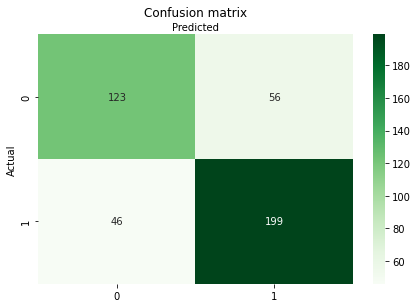

In [20]:
# implement a confusion matrix to show the accurate and inaccurate values
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_test = logreg.predict(X_test) #use our test matrix for comparison

#Creating the confusion matrix
c_matrix = confusion_matrix(y_test, y_pred_test)
classes=[0,1]

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

#Adding the heatmap
sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="Greens" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Looking at the confusion matrix of the test values, a majority of data is accurately processed, but about 1/4 of the data is inaccurate, as indicated by the score calculations from previously.

Text(0.5, 257.44, 'Predicted')

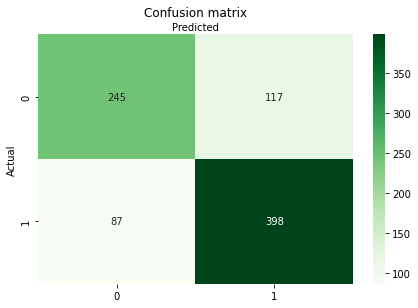

In [21]:
#test the confusion matrix over all inputs
y_pred = logreg.predict(x)

#Creating the confusion matrix
c_matrix = confusion_matrix(y, y_pred)
classes=[0,1]

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

#Adding the heatmap
sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="Greens" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Plotting the result of the whole dataframe, we see that the accuracy is similar to the previous example. This points to that the proportion of what is trained and tested matters more than the exact number of inputs.

The built in model does an okay job predicting these values, and a from-scratch model may be able to predict these values more accurately.